# Visualization with REFINED

In this notebook we show how to convert tabular data into images, and show those images for visualization. As it is explained in the main markdown, REFINED has two steps: Initialization with manifold learning techniques (MDS), and optimization with a search technique (hill climbing). Therefore to perform visualization with REFINED, we need to do the two steps and once we get the coordinate in the square image for each feature of the tabular data we can generate images associate with each datapoint (sample).

### 1. In the below cell we perform initialization with MDS

In [ ]:
!pip install fancyimpute
!pip install MPI
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746535 sha256=5f90ca4ca0eaf6365949add9faffe3316199f27e167de049a7ed0ff2c1d0cd71
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.misc
import sys
sys.path.append('/content/drive/MyDrive/REFINED')
import Toolbox
from Toolbox import two_d_eq, Assign_features_to_pixels
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import math
import os
# os.chdir('C:\\Users\\obazgir\\Desktop\\CMDS_IMAGES_NEW\\')
#%% Loading the data
# Feat_DF = pd.read_csv("normalized_padel_feats_NCI60_672.csv")
Feat_DF = pd.read_csv("/content/drive/MyDrive/REFINED/table.csv")
X = Feat_DF.values
X = X[:,2:]
original_input = pd.DataFrame(data = X)                              # The MDS input should be in a dataframe format with rows as samples and columns as features

feature_names_list = Feat_DF.columns.tolist()[2:]                 # Extracting feature_names_list (gene_names or descriptor_names)
print(len(feature_names_list))
print(">>>> Data  is loaded")

#%% MDS
nn = math.ceil(np.sqrt(len(feature_names_list)))    			     # Image dimension
Nn = original_input.shape[1] 										 # Number of features
transposed_input = original_input.T 							     # The MDS input data must be transposed , because we want summarize each feature by two values (as compard to regular dimensionality reduction each sample will be described by two values)
Euc_Dist = euclidean_distances(transposed_input) 					 # Euclidean distance
Euc_Dist = np.maximum(Euc_Dist, Euc_Dist.transpose())   			 # Making the Euclidean distance matrix symmetric
embedding = MDS(n_components=2)										 # Reduce the dimensionality by MDS into 2 components
mds_xy = embedding.fit_transform(transposed_input)					 # Apply MDS

print(">>>> MDS dimensionality reduction is done")

eq_xy = two_d_eq(mds_xy,Nn) # -> [0,1]
Img = Assign_features_to_pixels(eq_xy,nn,verbose=0)					# Img is the none-overlapping coordinates generated by MDS

#%% To be saved for hill climbing
Desc = Feat_DF.columns.tolist();    Desc = Desc[2:]					# Drug descriptors name
Dist = pd.DataFrame(data = Euc_Dist, columns = Desc, index = Desc)	# Generating a distance matrix which includes the Euclidean distance between each and every descriptor
data = (Desc, Dist, Img)  											# Preparing the hill climbing inputs

with open("Init_MDS_Euc.pickle", 'wb') as f:					# The hill climbing input is a pickle, therefore everything is saved as a pickle to be loaded by the hill climbing
    pickle.dump(data, f)

153
>>>> Data  is loaded


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


>>>> MDS dimensionality reduction is done


### 2. Hill Climbing
Once the initializaiton is performed, then we have to apply the search optimizaition (hill climbing). The below bash script will run the search optimization.

In [ ]:
# with MPI
!mpirun --allow-run-as-root --host localhost:2 -np 2 python3 /content/drive/MyDrive/REFINED/mpiHill_UF.py --init 'Init_MDS_Euc.pickle' --mapping 'Mapping_REFINED.pickle' --evolution "REFINED_Evolve.csv" --num 2

Processors found:  2
Time now at the beginning is:  2023-10-13 05:53:38.641570
Processors found:  2
Time now at the beginning is:  2023-10-13 05:53:38.641748
else
Initial corr: >>> [3.69454691]
/content/drive/MyDrive/REFINED/paraHill.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_array = np.array(results)
{(0, 0): 5, (0, 3): 6, (0, 6): 5, (0, 9): 9, (0, 12): 4, (3, 0): 3, (3, 3): 5, (3, 6): 4, (3, 9): 7, (3, 12): 1, (6, 0): 5, (6, 3): 5, (6, 6): 5}
> (0, 0) Corr: [3.69279476]
{(0, 1): 5, (0, 4): 6, (0, 7): 9, (0, 10): 4, (3, 1): 2, (3, 4): 5, (3, 7): 8, (3, 10): 7, (6, 1): 2, (6, 4): 7}
> (0, 1) Corr: [3.69133859]
{(0, 2): 6, (0, 5): 6, (0, 8): 5, (0, 11): 4, (3, 2): 7, (3, 5): 5, (3, 8): 8, (3, 11): 1, (6, 2): 3, (6, 5): 7}
> (0, 2) Corr: [3.69037319]
{

In [ ]:
# without MPI
from itertools import product
from scipy.spatial import distance
import paraHill



# Convert from 'F34' to int 34
init_map = np.char.strip(Img.astype(str),'F').astype(int)
map_in_int = init_map

iters_count = 2

for iter_num in range(iters_count):
    init_coords = [x for x in product([0,1,2],repeat = 2)]
    for init_coord in init_coords:
        # generate the centroids
        xxx = [init_coord[0]+i*3 for i in range(int(nn/3)+1) if (init_coord[0]+i*3)<nn]
        yyy = [init_coord[1]+i*3 for i in range(int(nn/3)+1) if (init_coord[1]+i*3)<nn]
        centr_list = [x for x in product(xxx,yyy)]
        swap_dict = paraHill.evaluate_centroids_in_list(centr_list,Dist,map_in_int)
        print(swap_dict)
        map_in_int = paraHill.execute_dict_swap(swap_dict, map_in_int)

        print(">",init_coord,"Corr:",paraHill.universial_corr(Dist,map_in_int))

        # print(">>>",n_iter,"Corr:",paraHill.universial_corr(dist_matr,map_in_int))
        # corr_evol.append(paraHill.universial_corr(dist_matr,map_in_int))

coords = np.array([[item[0] for item in np.where(map_in_int == ii)] for ii in range(Nn)])
# with open(args.mapping,'wb') as file:
#     pickle.dump([gene_names,coords,map_in_int],file)


/content/drive/MyDrive/REFINED/paraHill.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_array = np.array(results)


{(0, 0): 5, (0, 3): 6, (0, 6): 5, (0, 9): 9, (0, 12): 4, (3, 0): 3, (3, 3): 5, (3, 6): 4, (3, 9): 7, (3, 12): 1, (6, 0): 5, (6, 3): 5, (6, 6): 5, (6, 9): 3, (6, 12): 2, (9, 0): 9, (9, 3): 9, (9, 6): 6, (9, 9): 4, (9, 12): 5, (12, 0): 2, (12, 3): 1, (12, 6): 5, (12, 9): 4, (12, 12): 5}
> (0, 0) Corr: [3.68923851]
{(0, 1): 5, (0, 4): 6, (0, 7): 9, (0, 10): 4, (3, 1): 2, (3, 4): 5, (3, 7): 8, (3, 10): 7, (6, 1): 2, (6, 4): 7, (6, 7): 5, (6, 10): 3, (9, 1): 6, (9, 4): 6, (9, 7): 2, (9, 10): 3, (12, 1): 1, (12, 4): 1, (12, 7): 6, (12, 10): 4}
> (0, 1) Corr: [3.68273078]
{(0, 2): 6, (0, 5): 6, (0, 8): 5, (0, 11): 4, (3, 2): 7, (3, 5): 5, (3, 8): 8, (3, 11): 1, (6, 2): 3, (6, 5): 7, (6, 8): 5, (6, 11): 7, (9, 2): 8, (9, 5): 3, (9, 8): 5, (9, 11): 8, (12, 2): 1, (12, 5): 4, (12, 8): 6, (12, 11): 3}
> (0, 2) Corr: [3.68094064]
{(1, 0): 8, (1, 3): 7, (1, 6): 6, (1, 9): 4, (1, 12): 1, (4, 0): 8, (4, 3): 5, (4, 6): 5, (4, 9): 7, (4, 12): 1, (7, 0): 5, (7, 3): 8, (7, 6): 5, (7, 9): 3, (7, 12): 7, (

### 3. Visualization
Once the search optimization is performed and the coordinates for features are obtained, we can use the coordinates to generate images for visualization purpose or training CNNs. In the below code visualization is performed.

(19, 169)
(19, 169)


(-0.5, 12.5, 12.5, -0.5)

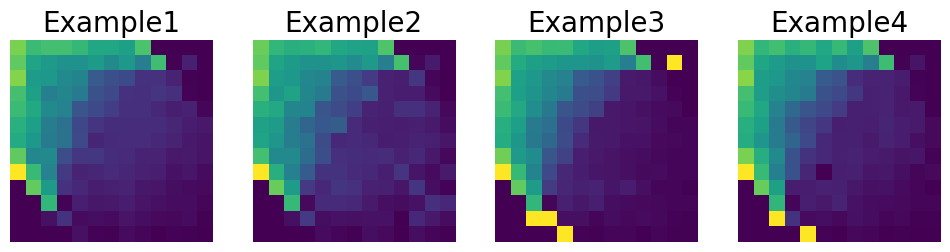

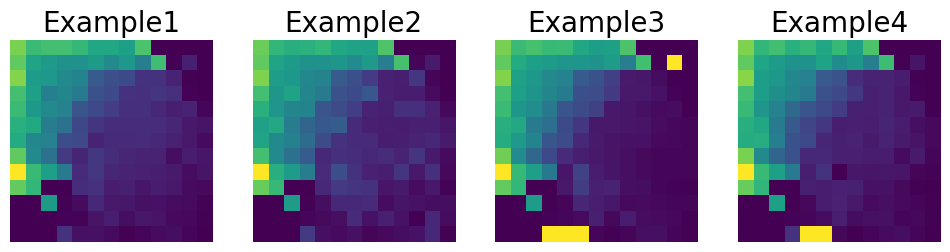

In [ ]:
#%% Visualizing REFFINED images
import math
import pickle
from Toolbox import REFINED_Im_Gen
# MDS
# with open('Mapping_REFINED.pickle','rb') as file:
#     gene_names_MDS,coords_MDS,map_in_int_MDS = pickle.load(file)

# We pick the first 100 data points because of computational costs, but you can pick the entire datasets.
X_REFINED_MDS = REFINED_Im_Gen(X[:,:],nn, map_in_int, Desc, coords)
# X_prev = REFINED_Im_Gen(X[:,:],nn, Img, Desc,Dist)
Font = 20
print(X_REFINED_MDS.shape)


fig=plt.figure(figsize=(12,8), dpi= 100)
plt.subplot(141)
plt.imshow(X_REFINED_MDS[1,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example1", fontsize = Font)
plt.axis('off')

plt.subplot(142)
plt.imshow(X_REFINED_MDS[2,:].reshape(nn, nn), cmap = 'viridis')
plt.title("Example2", fontsize = Font)
plt.axis('off')

plt.subplot(143)
plt.imshow(X_REFINED_MDS[3,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example3", fontsize = Font)
plt.axis('off')


plt.subplot(144)
plt.imshow(X_REFINED_MDS[4,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example4", fontsize = Font)
plt.axis('off')


#with MPI
with open('Mapping_REFINED.pickle','rb') as file:
    gene_names_MDS,coords_MDS,map_in_int_MDS = pickle.load(file)

# We pick the first 100 data points because of computational costs, but you can pick the entire datasets.
X_REFINED_MDS = REFINED_Im_Gen(X[:,:],nn, map_in_int_MDS, gene_names_MDS, coords_MDS)
# X_prev = REFINED_Im_Gen(X[:,:],nn, Img, Desc,Dist)
Font = 20
print(X_REFINED_MDS.shape)


fig=plt.figure(figsize=(12,8), dpi= 100)
plt.subplot(141)
plt.imshow(X_REFINED_MDS[1,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example1", fontsize = Font)
plt.axis('off')

plt.subplot(142)
plt.imshow(X_REFINED_MDS[2,:].reshape(nn, nn), cmap = 'viridis')
plt.title("Example2", fontsize = Font)
plt.axis('off')

plt.subplot(143)
plt.imshow(X_REFINED_MDS[3,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example3", fontsize = Font)
plt.axis('off')


plt.subplot(144)
plt.imshow(X_REFINED_MDS[4,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example4", fontsize = Font)
plt.axis('off')